In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install --upgrade mediapipe-model-maker

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.3/133.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.

In [ ]:
import tensorflow as tf
import keras
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

In [ ]:
from sklearn.model_selection import train_test_split
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_file = "/content/drive/MyDrive/daup/crop/dataset.zip"
extract_path = ""

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted to:", extract_path)


Files extracted to: 


In [ ]:
train_dir = 'dataset/train'
val_dir = 'dataset/validation'

In [20]:
os.makedirs(val_dir, exist_ok=True)

for category in ["healthy", "infected"]:
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

In [21]:
from sklearn.model_selection import train_test_split
import shutil

def split_data(source, destination, split_ratio=0.2):
    if not os.path.exists(source) or not os.listdir(source):
        raise ValueError(f"Source directory '{source}' does not exist or is empty.")

    images = [img for img in os.listdir(source) if img.lower().endswith((".jpg", ".png", ".jpeg"))]
    train_images, val_images = train_test_split(images, test_size=split_ratio, random_state=42)

    for img in val_images:
        shutil.move(os.path.join(source, img), os.path.join(destination, img))

for category in ["healthy", "infected"]:
    split_data(os.path.join(train_dir, category), os.path.join(val_dir, category))


In [25]:
import os
import shutil
import random

def split_data(source, destination, split_ratio=0.2):
    if not os.path.exists(source) or not os.listdir(source):
        raise ValueError(f"Source directory '{source}' does not exist or is empty.")

    images = [img for img in os.listdir(source) if img.lower().endswith((".jpg", ".png", ".jpeg"))]
    random.shuffle(images)  # Shuffle for randomness
    val_size = int(len(images) * split_ratio)

    val_images = images[:val_size]  # 20% validation images

    for img in val_images:
        shutil.move(os.path.join(source, img), os.path.join(destination, img))

train_dir = "dataset/train"
val_dir = "dataset/validation"

# Ensure validation folders exist
os.makedirs(val_dir, exist_ok=True)
for category in ["healthy", "infected"]:
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

# Reset any misplacements before re-splitting
for category in ["healthy", "infected"]:
    train_path = os.path.join(train_dir, category)
    val_path = os.path.join(val_dir, category)

    if os.path.exists(val_path):
        for img in os.listdir(val_path):
            shutil.move(os.path.join(val_path, img), os.path.join(train_path, img))  # Move everything back to train

# Perform correct splitting
for category in ["healthy", "infected"]:
    split_data(os.path.join(train_dir, category), os.path.join(val_dir, category))

print("Final Train directory:", {category: len(os.listdir(os.path.join(train_dir, category))) for category in ["healthy", "infected"]})
print("Final Validation directory:", {category: len(os.listdir(os.path.join(val_dir, category))) for category in ["healthy", "infected"]})


Final Train directory: {'healthy': 1356, 'infected': 1356}
Final Validation directory: {'healthy': 338, 'infected': 339}


In [26]:
def train_model():
    if not os.path.exists(train_dir) or not os.path.exists(val_dir):
        raise FileNotFoundError("Dataset directories not found. Check the dataset paths.")

    train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        brightness_range=[0.5, 1.5],
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(rescale=1.0/255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    if train_generator.samples == 0 or val_generator.samples == 0:
        raise ValueError("One of the datasets has zero images. Check dataset structure.")

    class_labels = np.array([0] * train_generator.samples + [1] * val_generator.samples)
    class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(), loss=tfa.losses.SigmoidFocalCrossEntropy(), metrics=['accuracy'])
    model.summary()

    model_save_path = 'models/crop_infection_model.keras'
    os.makedirs('models', exist_ok=True)

    checkpoint = ModelCheckpoint(
        model_save_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator,
        callbacks=[checkpoint, early_stopping],
        class_weight=class_weight_dict
    )

    return model, history

In [47]:
model=train_model()

Found 2712 images belonging to 2 classes.
Found 677 images belonging to 3 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                     

In [29]:
print(model)

(<keras.src.engine.sequential.Sequential object at 0x7925002fb890>, <keras.src.callbacks.History object at 0x7924cb326ed0>)


In [74]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 128)      

In [ ]:
# def predict_leaf(image_path):
#     model = load_model('models/crop_infection_model.keras')
#     img = cv2.imread(image_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (224, 224))
#     img_array = img / 255.0
#     img_array = np.expand_dims(img_array, axis=0)
#     prediction = model.predict(img_array)
#     pred_value = prediction[0][0]

#     gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     laplacian_var = cv2.Laplacian(gray_img, cv2.CV_64F).var()

#     if laplacian_var < 50:
#         reconstructed = cv2.GaussianBlur(img, (5, 5), 0)
#         reconstructed_gray = cv2.cvtColor(reconstructed, cv2.COLOR_RGB2GRAY)
#         reconstructed_var = cv2.Laplacian(reconstructed_gray, cv2.CV_64F).var()
#         if reconstructed_var < 50:
#             return 'uncertain or undetectable', (1 - pred_value) * 100

#     leaf_edges = cv2.Canny(gray_img, 50, 150)
#     if np.mean(leaf_edges) < 10:
#         return 'Not a valid picture', 0

#     if pred_value < 0.45:
#         return 'healthy', (1 - pred_value) * 100
#     elif pred_value > 0.55:
#         return 'infected', (1 - pred_value) * 100
#     else:
#         return 'Not a leaf', 0

In [36]:
# def predict_leaf(image_path):
#     model = load_model('models/crop_infection_model.keras')
#     img = cv2.imread(image_path)
#     if img is None:
#         return 'Invalid Image or Not Found', 0

#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (224, 224))
#     img_array = img / 255.0
#     img_array = np.expand_dims(img_array, axis=0)

#     prediction = model.predict(img_array)
#     pred_value = prediction[0][0]

#     gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     blur_score = cv2.Laplacian(gray_image, cv2.CV_64F).var()
#     edge_count = np.count_nonzero(cv2.Canny(gray_image, 100, 200))

#     print(f"Blur Score: {blur_score}, Edge Count: {edge_count}, Prediction Value: {pred_value}")
#     print(pred_value)
#     if pred_value < 0.0001:
#         return 'non-detectable object', 100
#     if blur_score < 10:
#         return 'uncertain or undetectable', (1 - pred_value) * 100
#     if edge_count < 500:
#         return 'Not a leaf', 0
#     if pred_value < 0.45:
#         return 'healthy', (1 - pred_value) * 100
#     if pred_value > 0.75:
#         return 'infected', (1 - pred_value) * 100
#     if 0.45 <= pred_value <= 0.55:
#         return 'not a leaf', 0

#     return 'uncertain or undetectable', (1 - pred_value) * 100
def predict_leaf(image_path):
    model = load_model('models/crop_infection_model.keras')
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img_array = img / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    pred_value = prediction[0][0]

    if pred_value < 0.45:
        return 'healthy', (1 - pred_value) * 100
    elif pred_value > 0.55:
        return 'infected', (1 - pred_value) * 100
    else:
        return 'Not a leaf', 0

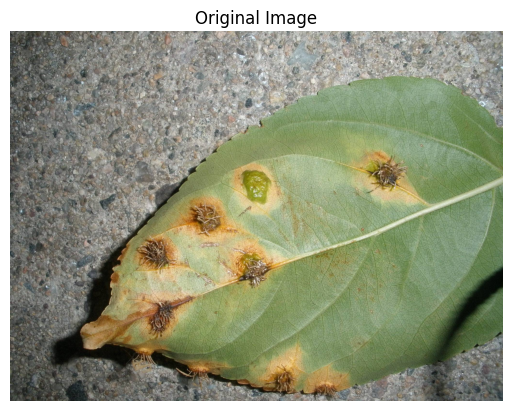

In [49]:
image = cv2.imread('leaf2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.show()

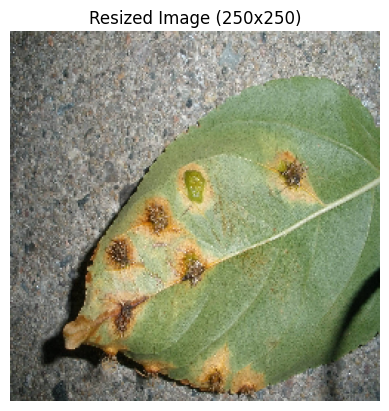

In [50]:
resized_image = cv2.resize(image, (250, 250))
plt.imshow(resized_image)
plt.title("Resized Image (250x250)")
plt.axis('off')
plt.show()

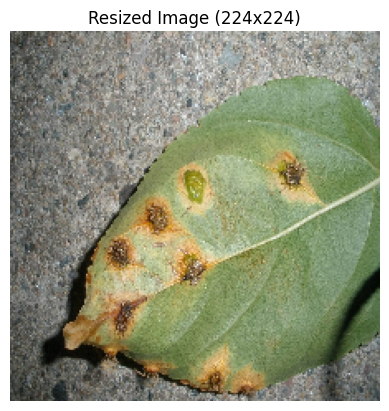

In [51]:
resized_image = cv2.resize(image, (224, 224))
plt.imshow(resized_image)
plt.title("Resized Image (224x224)")
plt.axis('off')
plt.show()

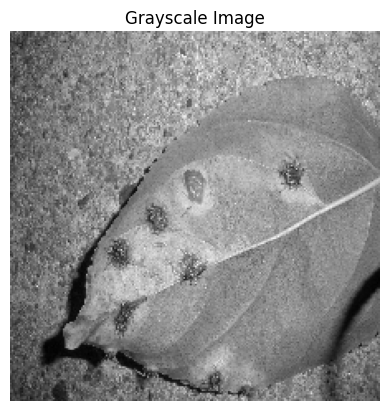

In [52]:
gray_image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_image, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()

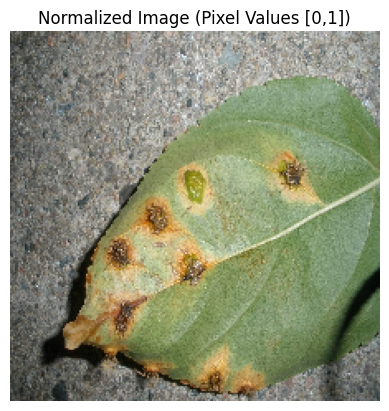

In [53]:
normalized_image = resized_image / 255.0
plt.imshow(normalized_image)
plt.title("Normalized Image (Pixel Values [0,1])")
plt.axis('off')
plt.show()

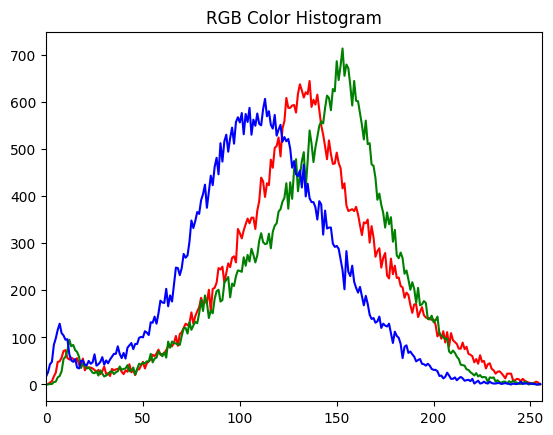

In [54]:
color = ('r', 'g', 'b')
plt.figure()
for i, col in enumerate(color):
    hist = cv2.calcHist([resized_image], [i], None, [256], [0, 256])
    plt.plot(hist, color=col)
    plt.xlim([0, 256])
plt.title("RGB Color Histogram")
plt.show()

In [55]:
glc_matrix = graycomatrix(gray_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
contrast = graycoprops(glc_matrix, 'contrast')[0, 0]
energy = graycoprops(glc_matrix, 'energy')[0, 0]
correlation = graycoprops(glc_matrix, 'correlation')[0, 0]
print(f"GLCM Contrast: {contrast}, Energy: {energy}, Correlation: {correlation}")

GLCM Contrast: 616.0336322869955, Energy: 0.011362595190664801, Correlation: 0.7968496314218999


In [58]:
from tensorflow.keras.preprocessing import image

In [ ]:
# def predict_leaf(image_path):
#     model = load_model('models/crop_infection_model.keras')
#     img = cv2.imread(image_path)

#     if img is None:
#         return 'Invalid Image or Not Found', 0

#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (224, 224))
#     img_array = img / 255.0
#     img_array = np.expand_dims(img_array, axis=0)

#     prediction = model.predict(img_array)
#     pred_value = prediction[0][0]

#     gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     blur_score = cv2.Laplacian(gray_image, cv2.CV_64F).var()
#     edge_count = np.count_nonzero(cv2.Canny(gray_image, 100, 200))

#     print(f"Blur Score: {blur_score}, Edge Count: {edge_count}, Prediction Value: {pred_value}")

#     if pred_value < 0.0001:
#         return 'non-detectable object', 100
#     if blur_score < 10:
#         return 'uncertain or undetectable', (1 - pred_value) * 100
#     if edge_count < 500:
#         return 'Not a leaf', 0
#     if pred_value < 0.50:
#         return 'healthy', (1 - pred_value) * 100
#     if pred_value > 0.75:
#         return 'infected', pred_value * 100
#     if 0.45 <= pred_value <= 0.55:
#         return 'not a leaf', 0

#     return 'uncertain or undetectable', (1 - pred_value) * 100

In [115]:
def predict_leaf(image_path):
    model = load_model('models/crop_infection_model.keras')
    img = cv2.imread(image_path)

    if img is None:
        return 'Invalid Image or Not Found', 0

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img_array = img / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    pred_value = prediction[0][0]

    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur_score = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    edge_count = np.count_nonzero(cv2.Canny(gray_image, 100, 200))

    print(f"Blur Score: {blur_score}, Edge Count: {edge_count}, Prediction Value: {pred_value}")

    if pred_value < 0.0001:
        return 'non-detectable object', 100
    if blur_score < 5:
        return 'uncertain or undetectable', (1 - pred_value) * 100
    if edge_count < 300:
        return 'Not a leaf', 0
    if pred_value < 0.77:
        return 'healthy', (1 - pred_value) * 100
    if pred_value > 0.75:
        return 'infected', pred_value * 100
    if 0.45 <= pred_value <= 0.55:
        return 'not a leaf', 0

    return 'uncertain or undetectable', (1 - pred_value) * 100

In [119]:
leaf_status, confidence = predict_leaf('ball.jpg')
print(f"Leaf Status: {leaf_status}, Confidence: {confidence:.2f}%")

Leaf Status: Invalid Image or Not Found, Confidence: 0.00%


In [ ]:
# leaf_status, confidence = predict_leaf('leaf1.jpeg')
# print(f"Leaf Status: {leaf_status}, Confidence: {confidence:.2f}%")